<a href="https://colab.research.google.com/github/samuel0922/TEAM_SSAMJI/blob/main/disease_detection_FasterRCNN_0918PP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Title : Disease Detection using Faster R-CNN with Python (v.0918PP1)
* 기본코드F에 데이터전처리 적용1 : albumentations
* Epoch : 1 - mAP Loss 491.5
---

## STEP 0. 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# GPU 확인. 코랩에서는 랜덤 GPU할당되므로 메모리 부족현상 발생 가능 -> GPU확인 후 메모리 충분할 경우 진행 권장

import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
# 라이브러리 임포트

import os
import glob
import json
import shutil as sh

# 바운딩박스 도식화 위한 패키지 임포트
import glob  # 파일, 디렉토리 처리
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  # matplotlib 시각화
import matplotlib.patches as patches
from bs4 import BeautifulSoup  # HTML, XML 파일 파싱, 웹스크래핑 

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision  # 이미지 처리를 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지 내장
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

import random

from tqdm import tqdm
import pandas as pd
from collections import Counter

from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## STEP 1. 데이터 준비
* 사용할 데이터셋을 준비(다운로드 또는 기 받아놓은 폴더 공유)
* 추천코드(FaceMask Detection)에서 사용하는 데이터셋 구조에 맞게 플젝(농작물 병해 진단) 데이터셋 구조를 맞춰 정리해줌 => 별도의 코드로 수행함
---
* 플젝(농작물 병해진단) 데이터셋은 마스크데이터 데이터셋과 다섯 가지 측면에서 차이가 있음
    * 데이터셋 폴더 구조가 다름
    * annotation 파일이 xlm파일이 아니고 json파일인 점
    * bbox 좌표 형식이 다름xml(x1,y1,x2,y2)->json(x,y,h,w)
    * label로 쓸 수 있는 직접적인 항목이 없음
    * 마스크검출에서 바운딩 박스, 레이블은 검출된 객체인 N개의 마스크에 대해서만 annotation에 있는 반면에, 플젝데이터셋의 annotation에는 이미지당 1개씩의 객체와 레이블(로 조합해 활용할 수 있는 항목들)이 있고, 병징을 나타내는 N개의 part에 대한 바운딩박스가 있다는 점에서 차이가 있음.

=> 각각에 대한 처리 방법은
1. 플젝의 데이터 구조를 그냥 두고 필요한 파일을 불러와서 처리하는 방식도 가능하겠지만, 혼란을 줄이고 처리를 용이하게 하기 위해서 디렉토리 구조를 마스크데이터셋처럼 맞춰줌
2. xml파일 대신 json파일에서 필요 정보 파싱해서 사용하면 됨
3. 상이한 좌표형식을 환산식을 사용해 처리
4. label로 쓸 수 있는 항목을 추출해 label로 쓸 수 있는 코드를 생성해 json 파일에 추가함
*5.(이 부분이 핵심임) 병징을 나타내는 N개의 정보(바운딩박스좌표, id)를 어떻게 활ㄹ용할 것인가?         

### S1-1P. 데이터 불러오기(농작물병해)

In [ ]:
# 플젝 데이터셋에서 데이터 불러와 확인을 위한 테스트 부분임

# %cd /content/drive/MyDrive/aiffelthon/PjtDataset/train
# !pwd

# train = glob.glob('*')
# print("train:",train)
# print(len(train))
# print(train[40])
# sample = glob.glob('train')
# print(len(sample))

# # train_image_sample = cv2.imread(glob.glob('train[40]'+'/*.jpg')[0])
# train_json_sample = json.load(open(glob.glob(train[40]+'/*.json')[0], 'r'))

# %cd /content/drive/MyDrive/aiffelthon/PjtDataset/train
# !pwd
# f_names = glob.glob('*')
# print(len(f_names))
# sample = f_names[40]

# sample_train_image = cv2.imread(glob.glob(sample+'/*.jpg')[0])
# print(sample_train_image)
# # train_json_sample = json.load(open(glob.glob(train[42]+'/*.json')[0], 'r'))

# with open((sample_train_image, "r") as json_file:
#     sample_train_json = json.load(open(glob.glob(sample+'/*.json')[0], 'r'))
#     sample_train_json['annotations'].append({
#     "label": "1_00_0"
#     })

In [ ]:
# 플젝 데이터셋에서 데이터 불러와 확인을 위한 테스트 부분임 : 이미지 파일 확인

# # image
# plt.imshow(cv2.cvtColor(train_image_sample, cv2.COLOR_BGR2RGB))
# plt.show()

In [ ]:
# 플젝 데이터셋에서 데이터 불러와 확인을 위한 테스트 부분임 : json파일 확인
# # json
# print(train_json_sample)
# print(train_json_sample['annotations']['area'])

### S2-1. 다운받은 농작물병해진단 데이터셋에서 train 데이터셋을 train과 validation 으로 분리해줌

* split-folder 모듈 
### S1-2. 데이터 분리 => 데이터셋 폴더구조 변경
* 데이터셋에서 훈련셋과 시험셋을 나눠줌
* 일반적으로 훈련셋:시험셋은 7:3으로 나누지만, 데이터셋이 적을 때는 8:2로 나눠주기도 함
=> 
* 플젝 데이터셋은 이미 test와 train 폴더로 나눠져 있기 때문에 이 작업은 필요하지 않음
* 다만, 마스크 데이터셋의 폴더구조는

    FaceMask Dataset
    - imges
        -   .png
    - annotations
        -   .xml
    => 인 것을 코드 내에서 test, train 으로 구분해 줌
    - image
    - test_image
    - annotations
    - test_annotations

* 플젝 데이터셋의 폴더구조는 다음과 같이 되어 있어서 이를 FaceMask 데이터셋의 폴더구조와 같게 맞춰주었음

    Pjtdataset(농작물 병해 데이터셋)
    - train
        - 10028
            -   .jpg
            -   .json
            -   .csv
    - test
        - 10000
            -   .jpg

    => 별도의 작업을 통해 다음과 같이 폴더구조를 만들어 줌

    Pjtdataset(농작물 병해 데이터셋)
        - train
            - images
                -   .jpg
            - annotations
                -   .json
        - test
            - images
                -   .jpg

### S2-2. 농작물병해진단 데이터셋 구조를 FaceMask 데이터셋 구조로 변경해 줌
* glob, shutil 모듈
* 대상작물폴더에 같이 들어있는 img파일(jpg)과 annotation파일(json)을 train과 val 폴더 밑에 각각 images, annotations 폴더로 나누어 줌

### S1-2P.데이터 확인 : 바운딩박스
* 플젝 baseline 코드에서 바운딩박스를 쳐주는 코드 발췌해 온 것임

In [ ]:
# # 플젝 baseline 코드에서 바운딩박스를 쳐주는 코드 발췌해 온 것임
# # visualize bbox
# plt.figure(figsize=(7,7))
# points = sample_json['annotations']['bbox'][0]
# part_points = sample_json['annotations']['part']
# img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# cv2.rectangle(
#     img,
#     (int(points['x']), int(points['y'])),
#     (int((points['x']+points['w'])), int((points['y']+points['h']))),
#     (0, 255, 0),
# )
# for part_point in part_points:
#     point = part_point
#     cv2.rectangle(
#         img,
#         (int(point['x']), int(point['y'])),
#         (int((point['x']+point['w'])), int((point['y']+point['h']))),
#         (255, 0, 0),
#         1
#     )
# plt.imshow(img)
# plt.show()

### S1-1B. 데이터 불러오기(마스크 데이터셋)

In [ ]:
# # 데이터로더 파일이 들어 있는 유틸리티 파일을 clone하고
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

# # 데이터로더 파일을 실행시켜 데이터셋을 다운로드 받음. --data 옵션에 FaceMaskDetection 파라미터를 줌
# !python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

In [ ]:
# # 다운받은 파일 압축 풀기

# !unzip -q Face\ Mask\ Detection.zip

## STEP 2. 데이터 전처리

### S2-3P. label 코드 만들기
* aanotaion 파일에 작물(crop), 병해(disease), 상태(risk)로 나누어져 있는 정보를 취합해서 레이블로 사용할 코드를 만들어 줌
* 학습 및 예측에서 사용할 수 있도록 레이블에 대한 encoder, decoder를 만들어 둠
* 생성한 레이블 코드를 annotaion파일에 label항목으로 추가해 줌


In [ ]:
# label 생성을 위해 개별 항목에 대한 코드(딕셔너리)화 작업.
# 변수 설명 csv 파일 참조

crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}

disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}

risk = {'1':'초기','2':'중기','3':'말기'}

In [ ]:
# label 생성 : 개별 항목에 대한 코드를 이용해 '작물_병해_진행단계' 형식으로 label 생성

label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

# # 클래스 갯수 확인
# print(len(label_description))

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [ ]:
# label 생성 : 생성한 label를 처리할 때 사용할 수 있게 encoder, decoder를 만들어둠
 
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
print(label_encoder['1_00_0'])
print(label_decoder[41])

0
3_00_0


In [ ]:
# # 데이터셋을 불러서 학습셋과 시험셋으로 분리해 줌

# # 데이터의 갯수를 확인해 봄
# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))

# # 테스트셋을 저장할 폴더를 만들어줌
# !mkdir test_images
# !mkdir test_annotations

# # 랜덤하게 수를 발생시켜 인덱스로 사용하고, random.sample()함수를 사용해 훈련셋과 시험셋으로 나눔
# random.seed(1234)
# idx = random.sample(range(853), 170)

# for img in np.array(sorted(os.listdir('images')))[idx]:
#     shutil.move('images/'+img, 'test_images/'+img)

# for annot in np.array(sorted(os.listdir('annotations')))[idx]:
#     shutil.move('annotations/'+annot, 'test_annotations/'+annot)

# # 나눈 후 각각의 폴더에 있는 데이터 갯수를 확인해 봄
# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))
# print(len(os.listdir('test_annotations')))
# print(len(os.listdir('test_images')))

### S1-X. json파일 읽어서 label항목을 만들어 추가해 줌

In [ ]:
# import glob
# train_annot_list = glob.glob('/content/drive/MyDrive/aiffel/Datathon/data/train/annotations/*')
# print(train_annot_list)

In [ ]:
# json파일에 있는 작물(crop), 병해(disease), 상태(risk) 정보를 파싱해서 
# label로 쓸 코드를 만들어 주는 코드 => 작업 완료

# import json
# for i, annot in enumerate(train_annot_list):

#     # if i == 10 :
#     #     break
#     with open(annot, "r") as file:
#         j_file = json.load(file)
#     # print(j_file)

#     label = str(j_file['annotations']['crop'])+"_"+str(j_file['annotations']['disease'])+"_"+str(j_file['annotations']['risk'])
#     print('i : ',i, ', label : ',label)
#     j_file['annotations']['label']=label 
#     # # j_file   
#     with open(annot, "w") as file:
#         json.dump(j_file, file)


In [ ]:
# # json파일 열어보기

# with open('/content/drive/MyDrive/aiffelthon/PjtDataset/train/annotations/58464.json', "r") as file:
#     sample = json.load(file)
# sample

In [ ]:
# # 병해객체 바운딩박스 인덱싱 확인

# print(sample['annotations']['bbox'][0]['x'])

In [ ]:
# # 병징(part) 바운딩박스 인덱싱 확인

# print(sample['annotations']['part'][0]['x'])

### S1-3. 바운딩박스 관련 함수 정의


In [ ]:
# 바운딩박스 관련 함수 내부 코드 작동 확인을 위한 부분임

# with open('/content/drive/MyDrive/aiffelthon/PjtDataset/train/19011/19011.json') as f:

#     # json파일을 읽어서 part
#     data = json.load(f)  # json파일을 읽어서
#     # soup = BeautifulSoup(data, "html.parser")
#     # objects = soup.find_all("object")  # object 항목들이 무엇인지 확인 요
#     print(data)
#     objects = data['annotations']['bbox']
#     print(objects)
# # 함수 내부 코드 확인을 위한 코드임

#     num_part = len(data['annotations']['bbox'])  # objects의 갯수를 할당해서 
#     print(num_part)

# boxes = generate_box(sample)

# pboxes = []

# for i in range(num_part):
#     # labels.append(generate_label(i))
#     # boxes.append(generate_box(i))
#     pboxes.append(generate_pbox(sample,i))
# labels = generate_label(sample)
# labels = torch.as_tensor(labels, dtype=torch.int64) 
# boxes = torch.as_tensor(boxes, dtype=torch.float32) 
# pboxes = torch.as_tensor(pboxes, dtype=torch.float32) 

# target = {}
# target["labels"] = labels
# target["boxes"] = boxes
# target["pboxes"] = pboxes

# print(target)

In [ ]:
# # generate_label()함수 내용 확인을 위한 부분임
# with open('/content/drive/MyDrive/aiffelthon/PjtDataset/train/annotations/19667.json', "r") as f:
#     data = json.load(f)

#     objects = data['annotations']
#     # print(objects)
#     # print(len(objects))
#     boxes = []
#     for i in objects :
#         label = objects['label']
#         # print(label)
#         label = label_encoder[label]

#     # print(objects)
#     # label = obj['annotations']['label']
#     # print(label)
#     # label = label_encoder[label]


In [ ]:
# 바운딩박스를 위한 함수들 정의

# 병해 객체에 대한 바운딩박스를 쳐주는 함수. 병해 객체는 하나의 이미지에 한 개만 있음
def generate_box(obj):
    '''
    annotation 파일에서 객체 bouding box 좌표를 읽어서 리턴함
    사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y)
    '''
    
    xmin = float(obj['annotations']['bbox'][0]['x'])  #find('xmin').text)
    ymin = float(obj['annotations']['bbox'][0]['y'])  #find('ymin').text)
    xmax = float(obj['annotations']['bbox'][0]['x']) + float(obj['annotations']['bbox'][0]['w'])  #find('xmax').text)
    ymax = float(obj['annotations']['bbox'][0]['y']) + float(obj['annotations']['bbox'][0]['h'])  #find('ymax').text)

    return [xmin, ymin, xmax, ymax]

'''
병징 관련된 부분(part)은 일단 배제
* 주의사항 : part(병징)정보가 없는 경우도 꽤 있음...추후 코드 구현시 참고바람

# N개의 병징들에 대해 바운딩박스를 쳐주는 함수 : 추천 코드에 없는데 추가한 부분임
# N개의 병징들은 

def generate_pbox(obj,i):
    
    #annotation 파일에서 질병(part) bouding box 좌표를 읽어서 리턴함
    #사용하는 bbox좌표 형식은 (좌상x, 좌상y, 우하x, 우하y, id)
    
    
    xmin_p = float(obj['annotations']['part'][i]['x'])  #find('xmin').text)
    ymin_p = float(obj['annotations']['part'][i]['y'])  #find('ymin').text)
    xmax_p = float(obj['annotations']['part'][i]['x']) + float(obj['annotations']['part'][i]['w'])  #find('xmax').text)
    ymax_p = float(obj['annotations']['part'][i]['y']) + float(obj['annotations']['part'][i]['h'])  #find('ymax').text)
    # id_p   = obj['annotations']['part'][i]['id']

    return [xmin_p, ymin_p, xmax_p, ymax_p]

adjust_label = 1  # adjust_lable : ??? <= 이게 왜 필요할까요?
'''

# 레이블을 생성해 주는 함수. 병해를 나타내는 레이블은 하나의 이미지당 1개임
# 마스크 디텍션에서 레이블은 3가지 경우의 수가 있고 if문으로 처리하였으나
# 농작물 병해는 작물_병해_진행단계 를 조합하여 만들어진 135개의 레이블이 있어
# 이를 처리해 주기 위해 encoder, decoder로 만들어 활용함

def generate_label(obj):  
    '''
    마스크착용상태 읽어서 레이블(정상착용, 비정상착용, 미착용)을 숫자로 리턴
    => json파일의 annotations에 추가한 label에서 읽어와서 할당하고 리턴함
    '''
    # print(obj)
    label = obj['annotations']['label']
    # print(label)
    label = label_encoder[label]

    return label
    # return 0 + adjust_label

# 이 함수가 대회용 baseline 모델에는 없는 부분이므로 내용 파악 잘 해야함
def generate_target(file): 
    '''
    generate_box(), generate_label()를 각각 호출해서 반환된 값을 딕셔너리에 저장해 반환
    html.parser()를 이용해 annotatin에 있는 내용을 불러와 타켓의 바운딩박스와 라벨에 추가함
    '''

    '''
    json파일을 읽어들여서
    한 개의 label과
    한 개의 대상객체 바운딩박스bbox와
    병해증상(part)의 갯수를 파악해서
        여러개의 병해증상 바운딩박스pbbox 를 리스트에 담은 후
    tensor에 할당하고
    target딕셔너리의 각 키값에 할당한 뒤
    리턴 
    '''
    print("file :",file)

    with open(file) as f:

        # json파일을 읽어서 part
        data = json.load(f)  # json파일을 읽어서
        # soup = BeautifulSoup(data, "html.parser")
        # objects = soup.find_all("object")  # object 항목들이 무엇인지 확인 요

        # 추천 코드에서와 마찬가지로 객체(여기서는 병해작물)를 objects로 할당
        # 그런데...마스크 디텍션에 쓰는 xml에서는 각각의 object 리스트 안에 
        # label('name')과 bbox좌표 등의 정보가 포함되어 있기 때문에 objects를 
        # get_boxe()나 get_label()의 매개변수로 넘겨주는 형식을 취함. 
        # 단, for문을 사용해 i로 넘겨주고 함수에서는 obj로 받는데..
        # 이 때 obj는 object 리스트임

        # 그런데... 농작물병해데이터셋 json에서는..annotation 아래로 bbox와 
        # label(생성해 준) 정보가 있는 점이 다름... 따라서... objects를 json에서
        # 어떤 단위에서 잡아줄 지 주의해야 하고, 함수에서 받았을 때 파싱에 유의해야 함  
        objects = data['annotations']

        '''
        일단 part에 대해 추가했던 이 부분도 배제

        # 마스크 디텍션 코드에서 objects 는 label이 붙는 검출된 다수의 마스크만을 의미하지만
        # 농작물 병해진단에서는 label이 붙는 객체는 1개이며, 대신 병징을 나타내는 여러개의 part로 구성됨
        num_part = len(data['annotations']['part'])  # objects(part)의 갯수를 할당해서 
        '''

        '''
        대신 추천코드에서 처럼 object(마스크 디텍션에서는 N개의 마스크)의 갯수를 찾아서 
        그 갯수만큼 처리해주는 방식으로 해 봄.. 병해는 이미지에 하나지만...
        '''

        num_objs = len(data['annotations']['bbox'])

        # 대상 객체를 나타내는 boxes와 label
        # 각 함수의 리턴값은 리스트 형태임
        labels = []
        boxes = []

        for i in objects :
            labels.append(generate_label(data)) 
            boxes.append(generate_box(data))
        
        '''
        # 병징을 나타내는 part들에 대한 좌표를 저장할 변수를 리스트로 선언해 주고
        pboxes = []

        # part(병징)의 수 만큼 for문을 돌려서 좌표를 구해서 pboxes리스트에 추가해줌
        for i in range(num_part):
            # labels.append(generate_label(i))
            # boxes.append(generate_box(i))
            pboxes.append(generate_pbox(data,i))
        '''
        # 저장된 labels, boxes, pboxes를 tensor로 저장
        # 일단, 원래 코드에 있는 데이터사이즈로 저장해 줌 => 이게 문젠가??
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        '''
        pboxes = torch.as_tensor(pboxes, dtype=torch.float32) 
        '''
        # 함수의 리턴값인 target에 패킹해줌
        target = {}
        target["labels"] = labels
        target["boxes"] = boxes 
        # 멘토님 추천 코드 : boxes.unsqueeze(dim=0) # (4) -> (N=1, 4)
        # 위에서 labels을 리스트로 선언해주고 함수에서 리턴받은 리스트값을 추가해 줌
        '''
        target["pboxes"] = pboxes
        '''
        return target

def plot_image_from_output(img, annotation):
    '''
    기존 마스크검출 코드의 내용임.
    이미지와 바운딩박스 함께 시각화
    마스크 착용시 green, 미 착용시 red, 잘못 착용시 orange
    
    데이터 탐색에서의 plot_image()는 이미지를 파일경로에서 읽어오지만
    plot_image_from_output()은 torch.tensor로 변환된 이미지를 시각화함
    '''
    
    # img = mping.imread(img_path) 
    img = img.cpu().permute(1,2,0)

    '''
    pytorch에서는 이미지를 [channel, height, width]형식으로 표현하는 반면
    matplotlib에서는 [height, width, channel]형식으로 표현하므로
    채널 순서를 바꿔주는 permute()함수를 활용해서 matplotlib에서 사용하기 위해
    채널 순서를 바꿔줌
    '''

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    '''
    annotation에서 bbox 좌표를 받아서 대상객체 바운딩 박스를 그려준다.
    '''
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()  ## 원래 코드 -> 플젝코드로 바꿔줘야 함
    
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=2,edgecolor='r',facecolor='none')
  
        ax.add_patch(rect)
    # ??? add_patch() 함수는 좌상x, 좌상y, h, w를 좌표로 해서 그림을 그려주는데...???
    # 아항.. w, h를 각각 Xmax - Xmin, Ymax-Ymin 으로 환산해서 값을 구해 적용해 주네 ㅋ
    # 그러면.. 애초에 json에서는 x, y, h, w로 좌표가 주어지니까 굳이 환산할 필요가 없네 ㅠㅠ
    # 요 부분은 나중에 ㅋ
    '''
    annotation에서 pbox들의 좌표를 받아서 여러개의 병해부위 바운딩 박스를 그려준다
    '''

    # for idx in range(len(annotation["pboxes"])):
    #     xmin, ymin, xmax, ymax = annotation["pboxes"][idx].cpu()  
    #         # .cpu()를 해주지 않으면 tensor관련 에러가 발생함

    #     rect_p = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
    #     ax.add_patch(rect_p)

    plt.show()

## STEP 3. 데이터셋 클래스와 데이터 로더 정의

* 파이토치 모델을 학습시키기 위해서 데이터셋 클래스를 정의해야 함

* torchvision에서 제공하는 객체탐지모델을 학습시키기 위한 데이터셋클래스의 __getitem__메서드는 이미지 파일과 바운딩박스 좌표를 반환함

* 최종적으로 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 torch.utils.data.DataLoader함수를 활용해 data_loader와 test_data_loader를 각각 정의함

* torch.utils.data.DataLoader() 함수를 통해 배치 사이즈를 4로 지정해 불러옴
* 배치 사이즈는 개인의 메모리 크기에 따라 자유롭게 설정하면 됨

In [ ]:
# # # sorted(os.listdir(path))) 동작 확인

# # path = '/content/drive/MyDrive/aiffelthon/PjtDataset/train/images'  # /content/drive/MyDrive/aiffelthon/PjtDataset/train
# # print(list((sorted(os.listdir(path)))))

# %cd /content/drive/MyDrive/aiffelthon/PjtDataset/test
# !pwd
# lists = glob.glob('./test_images_back')
# # for i, list in enumerate(lists):
# #     print('list: ',list)
#     # sh.copy('./test_images_bak/list','./test_images/')
#     # if i > 2000:
#     #     break

In [ ]:
# Dataset 경로

train_path = '/content/drive/MyDrive/aiffelthon/FarmDataset/train'
val_path = '/content/drive/MyDrive/aiffelthon/FarmDataset/val'

### S3-1. 기본코드(전처리 미적용)용 커스텀 데이터셋 클래스 정의 : FarmBasicDataset

In [ ]:
# # 농작물 병해 기본코드를 위한 데이터셋

# class FarmBasicDataset(object):
#     def __init__(self, transforms, path):
#         '''
#         path: path to train folder or test folder
#         '''
#         # transform module과 img path 경로를 정의
#         self.transforms = transforms
#         self.path = path
#         self.imgs = list(sorted(os.listdir(self.path)))
#         # print(self.path)
#         # print(self.imgs)

#     def __getitem__(self, idx): #special method
#         # load images ad masks
#         file_image = self.imgs[idx]
#         file_label = self.imgs[idx][:-3] + 'json'
#         img_path = os.path.join(self.path, file_image)
        
#         if 'val' in self.path:
#             label_path = os.path.join(val_path+"/annotations/", file_label)
#         else:
#             label_path = os.path.join(train_path+"/annotations/", file_label)

#         img = Image.open(img_path).convert("RGB")

#         # Generate Target
#         target = generate_target(label_path)
        
#         if self.transforms is not None:
#             img = self.transforms(img)

#         # print(img.shape)
#         # print(target.shape)

#         return img, target

#     def __len__(self): 
#         return len(self.imgs)

# data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
#         transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
#     ])
# '''
# 추후에 데이터전처리와 관련된 작업 내용을 Compose에 추가해야 함
# '''

# def collate_fn(batch):
#     return tuple(zip(*batch))

# dataset = FarmBasicDataset(data_transform, train_path+'/images/')
# test_dataset = FarmBasicDataset(data_transform, val_path+'/images/')

# # 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 
# # data_loader, test_data_loader를 각각 정의함
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

### S3-2. 데이터 전처리 적용 코드를 위한 커스텀 데이터셋 : 
* albumentation 적용

In [ ]:
# Albumentation 최신 버전 설치

# ! pip install albumentations==0.5.2.

In [ ]:
# 데이터셋 클래스 정의

class AlbumentationsDataset(Dataset):
    '''
    torchvision 데이터셋과 비슷한 구조
    cv2 모듈을 이용해 이미지를 읽고 RGB로 바꿔줌
    이미지 변환을 실시한 후 결과값을 반환함
    '''
    
    def __init__(self, transform, path):
        print('path: ',path)
        self.path = path
        print('self.path: ',self.path)
        self.imgs = list(sorted(os.listdir(self.path)))
        print("self.imgs: ",self.imgs)
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        print("idx: ",idx)
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'json'
        img_path = os.path.join(self.path, file_image)

        print(file_label)

        if 'val' in self.path:
            label_path = os.path.join(val_path+"/annotations/", file_label)
            print('test label_path:',label_path)
        else:
            label_path = os.path.join(train_path+"/annotations/", file_label)
            print('train label_path: ',label_path)
        
        # albumentation을 위해 추가된 부분 (시작)

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        target = generate_target(label_path)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # albumentation을 위해 추가된 부분 (끝)
            
        return image, target

# torchvision.transforms와 속도 비교를 위해 같은 함수들 사용해 처리
# Same transform with torchvision_transform

albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.Normalize(mean=0.5, std=0.5),  # 훈련시 오류에 대한 처리부분
    albumentations.pytorch.transforms.ToTensorV2()
])

def collate_fn(batch):
    return tuple(zip(*batch))

# 정의해 놓은 커스텀데이터셋 클래스(모델에 넘겨줄 학습용 또는 테스트용 
# 데이터셋을 구성해 주기 위한 클래스 ) 사용해서 학습용, 테스트용 데이터셋을 구성
# 매개변수는 앞에서 정의해 놓은 albumentation_transform과 경로
dataset = AlbumentationsDataset(albumentations_transform, train_path+'/images/')
print("train_path: ",train_path)
test_dataset = AlbumentationsDataset(albumentations_transform, val_path+'/images/')
print("test_path: ",val_path)

# 훈련용 데이터와 시험용 데이터를 batch단위로 불러올 수 있게 
# data_loader, test_data_loader를 각각 정의함
# 매개변수는 데이터셋, 배치사이즈, collate_fn
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

path:  /content/drive/MyDrive/aiffelthon/FarmDataset/train/images/
self.path:  /content/drive/MyDrive/aiffelthon/FarmDataset/train/images/
self.imgs:  ['10043.jpg', '10045.jpg', '10063.jpg', '10090.jpg', '10109.jpg', '10115.jpg', '10117.jpg', '10118.jpg', '10124.jpg', '10169.jpg', '10199.jpg', '10201.jpg', '10224.jpg', '10251.jpg', '10252.jpg', '10263.jpg', '10274.jpg', '10300.jpg', '10304.jpg', '10328.jpg', '10345.jpg', '10348.jpg', '10365.jpg', '10369.jpg', '10418.jpg', '10419.jpg', '10421.jpg', '10442.jpg', '10478.jpg', '10480.jpg', '10496.jpg', '10505.jpg', '10513.jpg', '10519.jpg', '10525.jpg', '10540.jpg', '10546.jpg', '10549.jpg', '10601.jpg', '10612.jpg', '10635.jpg', '10649.jpg', '10652.jpg', '10653.jpg', '10677.jpg', '10682.jpg', '10693.jpg', '10706.jpg', '10733.jpg', '10738.jpg', '10764.jpg', '10813.jpg', '10817.jpg', '10826.jpg', '10828.jpg', '10834.jpg', '10847.jpg', '10850.jpg', '10851.jpg', '10858.jpg', '10862.jpg', '10864.jpg', '10879.jpg', '10880.jpg', '10882.jpg', '10

### S1-4P. 플젝코드 참고 : 커스텀 데이터셋 클래스 정의

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, files, labels=None, mode='train'):
#         self.mode = mode
#         self.files = files
#         self.csv_feature_dict = csv_feature_dict
#         self.csv_feature_check = [0]*len(self.files)
#         self.csv_features = [None]*len(self.files)
#         self.max_len = 24 * 6
#         self.label_encoder = label_encoder

#     def __len__(self):
#         return len(self.files)
    
#     def __getitem__(self, i):
#         file = self.files[i]
#         file_name = file.split('/')[-1]
        
#         # csv
#         if self.csv_feature_check[i] == 0:
#             csv_path = f'{file}/{file_name}.csv'
#             df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
#             df = df.replace('-', 0)
#             # MinMax scaling
#             for col in df.columns:
#                 df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
#                 df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
#             # zero padding
#             pad = np.zeros((self.max_len, len(df.columns)))
#             length = min(self.max_len, len(df))
#             pad[-length:] = df.to_numpy()[-length:]
#             # transpose to sequential data
#             csv_feature = pad.T
#             self.csv_features[i] = csv_feature
#             self.csv_feature_check[i] = 1
#         else:
#             csv_feature = self.csv_features[i]
        
#         # image
#         image_path = f'{file}/{file_name}.jpg'
#         img = cv2.imread(image_path)
#         img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
#         img = img.astype(np.float32)/255
#         img = np.transpose(img, (2,0,1))
        
#         if self.mode == 'train':
#             json_path = f'{file}/{file_name}.json'
#             with open(json_path, 'r') as f:
#                 json_file = json.load(f)
            
#             crop = json_file['annotations']['crop']
#             disease = json_file['annotations']['disease']
#             risk = json_file['annotations']['risk']
#             label = f'{crop}_{disease}_{risk}'
            
#             return {
#                 'img' : torch.tensor(img, dtype=torch.float32),
#                 'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
#                 'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
#             }
#         else:
#             return {
#                 'img' : torch.tensor(img, dtype=torch.float32),
#                 'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
#             }

### S1-4P. 플젝코드 참고 : 데이터로더 설정

In [ ]:
# train = sorted(glob('data/train/*'))
# test = sorted(glob('data/test/*'))

# labelsss = pd.read_csv('data/train.csv')['label']
# train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

# train_dataset = CustomDataset(train)
# val_dataset = CustomDataset(val)
# test_dataset = CustomDataset(test, mode = 'test')

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

## STEP 4. 모델 불러오기 : Faster R-CNN

* 모델 개요
    * 이번 마스크 검출의 경우에 사용된 모델은 Faster R-CNN모델에 기반한 Mask R-CNN모델

    * Faster R-CNN모델은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델

    * Mask R-CNN 모델은 각 인스턴스에 대한 분할 마스크를 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델

* 전이학습(미리 학습된 모델을 가지고 와서 사용)
    * 첫번째, 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 방법
    * 두번째, 모델의 백본을 다른 백본으로 교체하는 것. 일테면 더 빠른 예측을 하려고 할 때(예:ResNet101에서 MobilenetV2로 교체하면 수행 속도 향상 기대. 단, 인식 성능은 저하될 수 있음)

* torchvision에서는 각종 컴퓨터 비전 문제를 해결하기 위한 딥러닝모델을 쉽게 불러올 수 있는 API를 제공함.
* torchvision.model.detection에서는 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpns)을 제공하고 있어 쉽게 구현이 가능 
* 이는 COCO데이터셋을 ResNet50기반으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정할 수 있음

* 이후 모델을 불러올 때는, 
* num_classes에 원하는 클래스 갯수를 설정하고 모델을 사용하면 됨
* Faster R-CNN 사용 시 주의할 점은, background 클래스를 포함한 갯수를 num_classes에 명시해주어야 함. -> 실제 데이터셋의 클래스 갯수에 1개를 더해 backgrond 클래스 갯수를 추가해 주어야 함

In [ ]:
# 모델 불러오는 함수 정의 : [retrain된 fasterrcnn_resnet50_fpn 모델
# 미리 학습된 모델로부터 특정 클래스를 위해 미세 조정 
def get_model_instance_segmentation(num_classes):
    # COCO로 미리 학습된 모델 할당
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의해 줌
    # num_classes = 2  # 1 클래스(작물) + 배경

    # 분류기에 넣어줘서 사용할 입력 특징의 차원 정보(갯수)를 얻음
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 마스크 예측기를(미리 학습된 모델의 머리 부분)을 새로운 것으로 교체함
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 만일 모델을 일부 수정하려는 경우는 다음과 같이 사용함
    '''
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    hidden_layer = 256
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, hidden_layer, num_classes)
    '''
    
    return model

## STEP 5. 전이 학습
* FaceMaskDetection에 전이 학습을 실시해 봄
* FaceMaskDetection 데이터셋은 3개의 클래스로 이루어져 있지만, background 클래스를 포함해 num_classes를 4로 설정한 후 모델을 불러와야 함
* GPU를 사용할 수 있는 환경이라면 device로 지정해 불러온 모델을 GPU에 보내줌
=>
* 플젝(농작물 병해 진단)에 전이 학습을 실시해 봄
* 플젝(농작물 병해 진단) 데이터셋은 1개의 클래스로 이루어져 있지만, background 클래스를 포함해 num_classes를 2로 설정한 후 모델을 불러오
* GPU를 사용할 수 있는 환경이라면 device로 지정해 불러온 모델을 GPU에 보내줌

In [ ]:
# get_model_instance_segmentation()으로 모델 불러옴. 파라미터 4는 클래스의 수
# 클래스 3개 + 배경 클래스 1개 = 4

model = get_model_instance_segmentation(112)

# GPU를 사용할 수 있으면 모델을 GPU에 보내줌
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

## STEP 6. 모델 학습

In [ ]:
# 모델 학습. epoch지정해 주고, optimizer도 지정해 줌(여기선 SGD)

num_epochs = 1
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
# data_loader에서 한 배치씩 순서대로 모델에 사용하며, 이후 loss 계산을 통해 최적화 수행
# 각 epoch마다 출력되는 loss를 통해 학습이 진행되는 것을 확인할 수 있음

print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1

        # 이미지 넘겨받은 것을 GPU에 할당
        imgs = list(img.to(device) for img in imgs)

        # annotations 넘겨받은 것을 GPU에 할당..
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        ##################################################################
        # print(len(imgs))
        # print(len(annotations))

        # 1, 2, 3, 4
        # [1, 2, 3, 4] <- list라서 tensor의 차원이 없음
        # torch.cat([1, 2, 3, 4], dim=0) <- (N,) Tensor의 차원이 생김
        # annotations = torch.cat(annotations, dim=0) # batch dimension 추가
        ##################################################################

        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 491.5052795410156, time : 1795.7643465995789


In [ ]:
# torch.save() : 학습시킨 가중치를 저장해 두고 나중에 언제든지 불러와 사용
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## STEP 7. Inference
* 모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해 봄
* 예측결과에는 바운딩박스의 좌표(bbox)와 클래스(label), 점수(scores)가 포함됨
* 점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데..
* make_prediction : treshhold값이 0.5이상인 것만 추출하도록 설정해주는 파라미터
* test_data_loader의 첫번째 배치에 대해서만 결과 출력

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]

        ''' 이 부분은 일단 배제
        preds[id]['pboxes'] = preds[id]['pboxes'][idx_list]
        ''' 
        
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

    ''' 
    Error : 10027.json은 없는 파일인데 열려고 해서 생기는 오류 => 왜?
    <ipython-input-22-8d6b95dd040f> in generate_target(file)
        75     
        76 
    ---> 77     with open(file) as f:
        78 
        79         # json파일을 읽어서 part

    FileNotFoundError: [Errno 2] No such file or directory:
    '/content/drive/MyDrive/aiffelthon/FarmDataset/train/annotations/10027.json'

    => 해결 : test이 경우 경로 지정의 조건에 'test'가 포함되었는지 여부로 했는데
            새롭게 데이터셋 정리하면서 'val'로 했기 때문에 train과 test인 경우의
            경로 지정이 구분되지 못함
    '''

idx:  0
10027.json
test label_path: /content/drive/MyDrive/aiffelthon/FarmDataset/val/annotations/10027.json
idx:  1
10037.json
test label_path: /content/drive/MyDrive/aiffelthon/FarmDataset/val/annotations/10037.json
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


Target :  tensor(41)


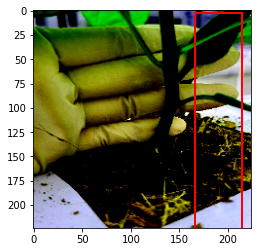

IndexError: ignored

In [ ]:
# 예측된 결과를 이용해 이미지 위에 바운딩 박스를 그려봄
# 위에서 정의한 plot_image_from_output()함수로 그림을 출력함
# Target이 실제 바운딩 박스 위치,, Prediction이 모델이 예측한 결과

_idx = 1

# 실제 바운딩 박스 위치
print("Target : ", annotations[_idx]['labels'][0])
plot_image_from_output(imgs[_idx], annotations[_idx])

# 모델이 예측한 바운딩 박스 위치 결과
print("Prediction : ", pred[_idx]['labels'][0])
plot_image_from_output(imgs[_idx], pred[_idx])

## STEP 8. 평가
* 전체 시험 데이터에 대해 예측 결과를 평가해 봄


### S8-1. 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 preds_adj_all, annot_all에 담아줌

In [ ]:
# 모든 시험 데이터에 대한 예측 결과와 실제 label을 
# 각각 preds_adj_all, annot_all에 담아줌

from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

### S8-2. mAP값을 산출
* Tutorial-Book-Utils 폴더 내에 있는 utils_ObejctDetection.py 파일을 통해 mAP값을 산출

In [ ]:
%cd /content/drive/MyDrive/Tutorial-Book-Utils/
import utils_ObjectDetection as utils

In [ ]:
# get_batch_statistics 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 
# 바운딩 박스간의 통곗값을 계산후
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

# ap_per_class 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

## 회고

* AP값은 검출한 클래스에 대해서 보여줍니다. 

* epoch30으로 학습한 결과 AP는 1.009의 정확도를 보이고 loss는 0.43 정도에 수렴하고 있지만, RetinaNet 결과보다는 향상된 것을 확인할 수 있습니다. 


* RetinaNet이 FPN과 Focal loss로 one-stage method임에도 높은 성능을 보인다고 일반적으로 알려져 있습니다. 

* 물론 하이퍼파라미터 튜닝을 통해 RetinaNet의 성능을 최적화 해도 되겠지만, 현재 실험 결과로 미뤄봤을 때 이 데이터셋에는 Faster-RCNN이 더 좋은 성능을 보이고 있습니다.

* 이제 전처리를 통해서 결과가 어떻게 되는지 확인해서 비교해 보겠습니다.